This is a notebook containing a more in-depth analysis and experimentation on the generation of orthogonal feature spaces.
A more direct implementation can be found in [simulation.py](./simulation.py).

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV, BandedRidgeCV
from scipy.stats import zscore

In [6]:
np.random.seed(42)
backend = set_backend("cupy")
plt.style.use("nord")
sns.set_theme(style="whitegrid")

In [7]:
n_samples_train = 10000
n_samples_test = 1000
n_targets = 10000
d_list = [100, 100, 100]
scalars = [1/3, 1/3, 1/3]
noise_scalar = 0.1
hidden_feature_space_names = ["A", "B", "C"]
researcher_feature_space_names = [r"$X_1$", r"$X_2$"]

# Generate features

## Start with random matrix $M$

In [8]:
M = np.random.randn(n_samples_train + n_samples_test, sum(d_list))
M = zscore(M, axis=0)

## SVD

In [9]:
U, S, Vt = np.linalg.svd(M, full_matrices=False)
print(U.shape, S.shape, Vt.shape)

(11000, 300) (300,) (300, 300)


Text(7.819444444444452, 0.5, 'value')

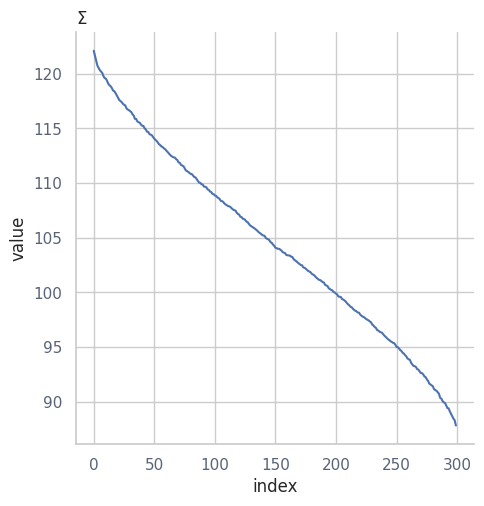

In [10]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$")
plt.xlabel("index")
plt.ylabel("value")

### Shuffle U, S and V indices to remove singular value order

In [11]:
# index_shuffle = list(range(U.shape[1]))
# random.shuffle(index_shuffle)
# U = U[:, index_shuffle]
# S = S[index_shuffle]
# Vt = Vt[index_shuffle, :]

Normalize $\Sigma$

In [12]:
print(np.var(U @ np.diag(S) @ Vt))
S = np.ones_like(S)
print(np.var(U @ np.diag(S) @ Vt))

0.9999999999999991
9.090909090909075e-05


Text(2.6944444444444517, 0.5, 'value')

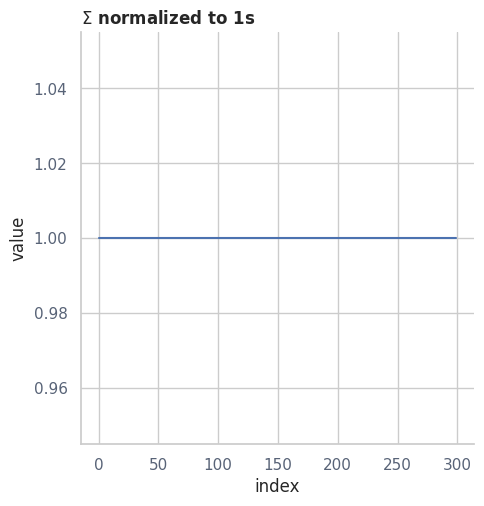

In [13]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$ normalized to 1s")
plt.xlabel("index")
plt.ylabel("value")

Split up S to create three orthogonal matrices to be used as feature spaces

In [14]:
feature_spaces = []

start = 0
for rank in d_list:
    _S = np.zeros(len(S))
    _S[start:start + rank] = S[start:start + rank]

    diag_S = np.diag(_S)

    space = U @ diag_S @ Vt
    space = zscore(space, axis=0)
    feature_spaces.append(space)
    start += rank

#### make sure that all feature spaces are orthogonal to each other (histograms should be nearly 0)

In [15]:
# matmuls_df = pd.DataFrame()
#
# for i in range(len(feature_spaces)):
#     for j in range(i + 1, len(feature_spaces)):
#         first_transposed = feature_spaces[i].T @ feature_spaces[
#             j]
#         matmuls_df = pd.concat([
#             matmuls_df,
#             pd.DataFrame(
#                 {'Features': [f"{hidden_feature_space_names[i]}.T x {hidden_feature_space_names[j]}"],
#                  'Values (avg across samples)': [first_transposed.mean(axis=0)]}), ], ignore_index=True)
#
# for i in range(len(feature_spaces)):
#     for j in range(i + 1, len(feature_spaces)):
#         second_transposed = feature_spaces[i] @ feature_spaces[j].T
#         matmuls_df = pd.concat([
#             matmuls_df,
#             pd.DataFrame(
#                 {'Features': [f"{hidden_feature_space_names[i]} x {hidden_feature_space_names[j]}.T"],
#                  'Values (avg across samples)': [second_transposed.mean(axis=0)], }),
#         ], ignore_index=True)
# matmuls_df

In [16]:
# sns.displot(data=matmuls_df.explode("Values (avg across samples)"), x="Values (avg across samples)", multiple="stack",
#             hue="Features", bins=30)
# plt.suptitle("Feature space matrix multiplications", y=1.02)

# Generate weights

In [17]:
betas = [zscore(np.random.randn(sum(d_list), n_targets)) for _ in d_list]

# create targets

In [18]:
Y = sum([(alpha ** 0.5) * zscore(feature_space @ beta) for alpha, feature_space, beta in
         zip(scalars, feature_spaces, betas)])
Y = zscore(Y)


## add noise

In [19]:
noise = zscore(np.random.randn(n_samples_train + n_samples_test, n_targets), axis=0)
noise *= noise_scalar ** 0.5
print(noise.var())

0.1000000000000004


In [20]:
Y += noise
print(Y.var())
Y = zscore(Y)

1.0999869331474197


Create plot of variances

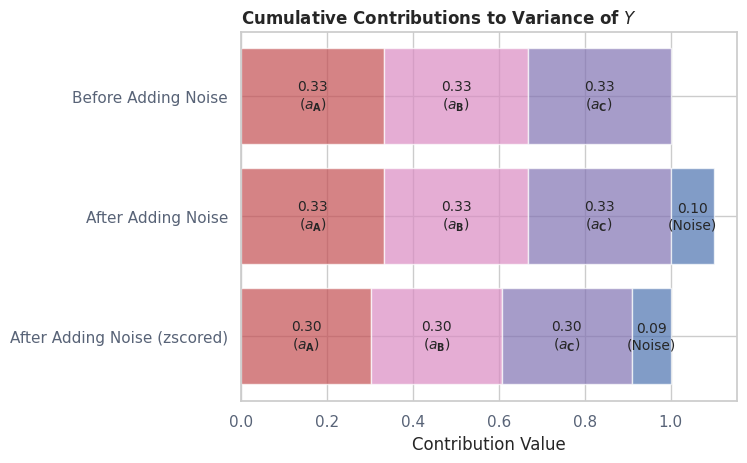

In [21]:
alphas_cumulative = np.cumsum(scalars)
scalars_with_noise = scalars + [noise_scalar]
alphas_cumulative_with_noise = np.cumsum(scalars_with_noise)
alphas_labels = [f"Alpha {i + 1}" for i in range(len(alphas_cumulative))]

# Plot the third set of bars stacked on top
bars3 = plt.barh(["After Adding Noise (zscored)"], np.array(scalars_with_noise) / sum(scalars_with_noise),
                 left=[0] + list(alphas_cumulative_with_noise[:-1] / 1.1),
                 color=["C3", "C6", "C4", "C0"], alpha=0.7)
for i, (bar, scalar) in enumerate(zip(bars3, (np.array(scalars_with_noise) / sum(scalars_with_noise)))):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
             f"{scalar:.2f}\n({[r"$a_\mathbf{A}$", r"$a_\mathbf{B}$", r"$a_\mathbf{C}$", 'Noise'][i]})",
             ha='center', va='center', fontsize=10)

# Plot the second set of bars stacked on top
bars2 = plt.barh(["After Adding Noise"], scalars_with_noise, left=[0] + list(alphas_cumulative_with_noise[:-1]),
                 color=["C3", "C6", "C4", "C0"], alpha=0.7)
for i, (bar, scalar) in enumerate(zip(bars2, scalars_with_noise)):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
             f"{scalar:.2f}\n({[r"$a_\mathbf{A}$", r"$a_\mathbf{B}$", r"$a_\mathbf{C}$", 'Noise'][i]})",
             ha='center', va='center', fontsize=10)

# Plot the first set of bars
bars1 = plt.barh(["Before Adding Noise"], scalars, left=[0] + list(alphas_cumulative[:-1]), color=["C3", "C6", "C4"],
                 alpha=0.7)
for i, (bar, scalar) in enumerate(zip(bars1, scalars)):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
             f"{scalar:.2f}\n({[r"$a_\mathbf{A}$", r"$a_\mathbf{B}$", r"$a_\mathbf{C}$"][i]})",
             ha='center', va='center', fontsize=10)

plt.title(r"Cumulative Contributions to Variance of $Y$")
plt.xlabel("Contribution Value")
plt.show()

# train simple linear models to confirm feature spaces predict the target

In [22]:
scores = pd.DataFrame()

for feature_space, hidden_name, scalar in zip(feature_spaces, hidden_feature_space_names, scalars):
    model = RidgeCV()
    model.fit(feature_space[:n_samples_train], Y[:n_samples_train])
    score = model.score(feature_space[n_samples_train:], Y[n_samples_train:])
    scores = pd.concat([
        scores,
        pd.DataFrame({'feature space': [hidden_name], 'Score': [score],
                      'EV': [scalar]})], ignore_index=True
    )

scores

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/backend/_utils.py:138: UserWarning: GPU backend cupy is much faster with single precision floats (float32), got input in float64. Consider casting your data to float32.
  warnings.warn(


OutOfMemoryError: Out of memory allocating 1,280,000,000 bytes (allocated so far: 2,451,047,936 bytes).

In [ ]:
plot = sns.catplot(scores, x="feature space", y="Score", kind="bar").set_axis_labels("Feature Space", "Score")
for index, row in scores.iterrows():
    plot.ax.axhline(row["EV"], color='red', linestyle="--", linewidth=1.5,
                    xmin=index / 3, xmax=(index + 1) / 3,
                    label=f'EV' if index == 0 else None)
plot.ax.legend()
plt.title("Feature space scores")

Create researcher feature spaces

In [ ]:
Xs = [np.hstack([feature_spaces[0], feature_space]) for feature_space in feature_spaces[1:]]

now train on researcher side feature spaces

In [ ]:
researcher_scores = pd.DataFrame()

linear_models = [RidgeCV() for _ in range(len(Xs))]
for i, model in enumerate(linear_models):
    model.fit(Xs[i][:n_samples_train], Y[:n_samples_train])
    score = model.score(Xs[i][n_samples_train:], Y[n_samples_train:])
    researcher_scores = pd.concat([
        researcher_scores,
        pd.DataFrame({'feature space': [researcher_feature_space_names[i]], 'Score': [score],
                      'EV': scalars[0] + scalars[i + 1]})],
        ignore_index=True
    )
researcher_scores

In [ ]:
plot = sns.catplot(researcher_scores, x="feature space", y="Score", kind="bar").set_axis_labels("Feature Space",
                                                                                                "Score")
for index, row in researcher_scores.iterrows():
    plot.ax.axhline(row["EV"], color='red', linestyle="--", linewidth=1.5,
                    xmin=index / 2, xmax=(index + 1) / 2,
                    label=f'EV' if index == 0 else None)
plot.ax.legend(title="Theoretical EV")
plt.title("Researcher side feature space scores")

In [ ]:
Xs_train = [x[:n_samples_train] for x in Xs]
Xs_test = [x[n_samples_train:] for x in Xs]
joint_model = BandedRidgeCV(groups="input", solver_params=dict(n_iter=10))
joint_model.fit(Xs_train, Y[:n_samples_train])
score = joint_model.score(Xs_test, Y[n_samples_train:])

In [ ]:
sns.displot(backend.to_numpy(score))